In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Online learning vs batch for non-stationary distributions

Aim: generate data from distributions that are non stationary over time, compare a SGD with Logistic Regression. We will train a SGD classifier with a log loss function and a logistic regression classifier to the same initial data, and then compare performance on new data. The SGD classifier will be updated online.

## Generate data

Define a generator and a function to collect specified amount of data in numpy arrays ready to be passed to models. The centroids of the distributions are fixed in the x1 dimension, and oscillate in the x2 dimension (try plotting cos(freq * t) if you arent sure what this behaviour will look like!)

In [2]:
def generate_lin_cls(mean_a, mean_b, cov_a, cov_b, freq = 0.003, seed = 1234):
    '''
    generator to create data from two distributions a and b described by a mean and
    covariance.
    The mean oscilates with frequency freq
    '''
    np.random.seed(seed)
    t = 0
    while True:
        mean_a_ = [mean_a[0], np.cos(freq * t) * mean_a[1]]
        mean_b_ = [mean_b[0], np.cos(freq * t) * mean_b[1]]
        if np.random.uniform() > 0.5:
            yield np.random.multivariate_normal(mean_a_, cov_a, 1)[0], np.array([0], dtype = 'int64')
        else:
            yield np.random.multivariate_normal(mean_b_, cov_b, 1)[0], np.array([1], dtype = 'int64')
        t += 1
        
        
def collect_batch(batch_size, n_features, data_gen):
    '''
    collect a batch of batch_size observations from 
    a generator
    '''
    x = np.empty([batch_size, n_features])
    y = np.empty(batch_size, dtype = 'int64')
    for i in range(batch_size):
        x_, y_ = next(data_gen)
        x[i,:] = x_
        y[i] = y_
    return x, y

### Visualise data we are producing

Generate 2000 points to plot distributions over time.

In [3]:
gen = generate_lin_cls(mean_a = [1.0,1.5], 
                       mean_b = [-1.0,-1.5], 
                       cov_a = [[1.0,0.0], [0.0,1.0]], 
                       cov_b = [[1.0,0.0], [0.0,1.0]]
                      )
# collect 2000 points
X, y = collect_batch(2000, 2, gen)

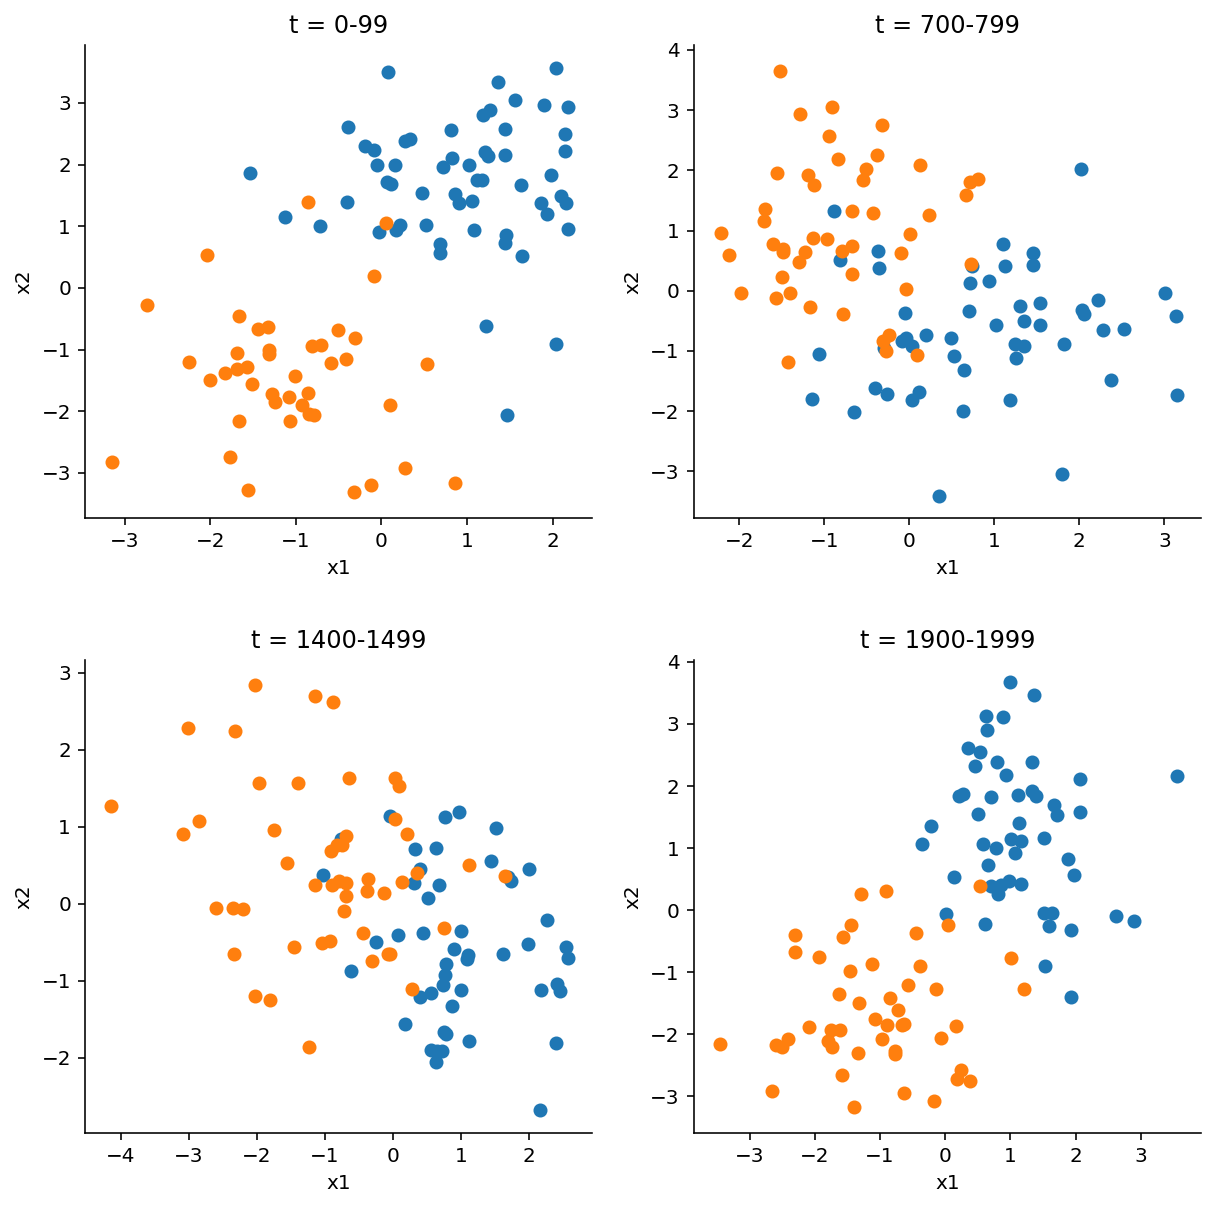

In [4]:
# We see slowly oscillating class centroids in x2 direction
# when we consider most recent 100 points at a time

f, axarr = plt.subplots(2, 2, figsize = (10,10))

t_int = [(0,99), (700,799), (1400,1499), (1900,1999)]
ax_coord = [[0,0], [0,1], [1,0], [1,1]]

for i in range(2):
    for j in range(2):
        axarr[i,j].spines['top'].set_visible(False)
        axarr[i,j].spines['right'].set_visible(False)
        axarr[i,j].set_xlabel('x1')
        axarr[i,j].set_ylabel('x2')
        

for a, t in zip(ax_coord, t_int):
    t_lower = t[0]
    t_upper = t[1]
    
    X_tmp = X[t_lower:t_upper]
    y_tmp = y[t_lower:t_upper]

    for label in [0, 1]:
        mask = (y_tmp == label)
        x1 = X_tmp[mask, 0]
        x2 = X_tmp[mask, 1]
        axarr[a[0], a[1]].scatter(x1, x2, label = 'class {}'.format(label))

    axarr[a[0], a[1]].set_title('t = {}-{}'.format(t_lower, t_upper))

f.subplots_adjust(hspace = 0.3);

## Train models

Start by re initialising our data generator.

We will then train an SGD classifier and a logisitic regression to an initial 100 points. Our objective is to compare performance of the batch trained logisitic regression vs the online SGD model, which will be continuosly updated.

In [6]:
gen = generate_lin_cls(mean_a = [1.0,1.5], 
                       mean_b = [-1.0,-1.5], 
                       cov_a = [[1.0,0.0], [0.0,1.0]], 
                       cov_b = [[1.0,0.0], [0.0,1.0]]
                      )

X_init, y_init = collect_batch(100, 2, gen)

# scale the data- may not be needed in this toy example,
# but usually required for SGD to converge well
scaler = StandardScaler().fit(X_init)

### Train the SGD model

In [7]:
# log loss = logistic regression
sgd_est = SGDClassifier(loss = 'log', 
                        max_iter = 500, 
                        random_state = 1234, 
                        warm_start= False)

# candidate hyperparams
sgd_param_grid = dict(alpha=[0.001, 0.01, 0.1, 1, 10],
                      eta0=[0.001, 0.01, 0.1, 1, 10],
                      l1_ratio = [0.0, 0.15 ,0.25, 0.5, 0.75, 1.0],
                      learning_rate =['constant']
                      )

# grid search with CV
grid_search_sgd = GridSearchCV(estimator=sgd_est,
                              param_grid=sgd_param_grid,
                              scoring='accuracy',
                              n_jobs=1,
                              cv=3,
                              refit=True,
                              verbose=1)

# fit
grid_search_sgd.fit(scaler.transform(X_init), y_init)

# pull out the final model
sgd_cls = grid_search_sgd.best_estimator_

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:    2.4s finished


In [8]:
print('Chosen params: {}\n\nTrain Accuracy: {:0.3f}'.format(grid_search_sgd.best_params_,
                                                        grid_search_sgd.best_score_))

Chosen params: {'alpha': 0.1, 'eta0': 0.001, 'l1_ratio': 0.0, 'learning_rate': 'constant'}

Train Accuracy: 0.950


### Train the logistic regression model

In [9]:
# now just a standard linear model
lr_est = LogisticRegression(penalty='l2')

lr_param_grid = dict(C = [0.001, 0.01, 0.1, 1, 10])

grid_search_lr = GridSearchCV(estimator = lr_est,
                              param_grid = lr_param_grid,
                              scoring = 'accuracy',
                              n_jobs = 3,
                              cv = 3,
                              refit = True,
                              verbose = 1)

grid_search_lr.fit(scaler.transform(X_init), y_init)

# extract model
lr_cls = grid_search_lr.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:    0.1s finished


In [10]:
print('Chosen params: {}\n\nTrain Accuracy: {:0.3f}'.format(grid_search_lr.best_params_,
                                                        grid_search_lr.best_score_))

Chosen params: {'C': 0.001}

Train Accuracy: 0.940


## Compare the models over time

We know the logistic regression will perform well when the configuration is similar to where it was trained, and will perform very poorly otherwise. We are interested to see if our online model will perform better.

We will perform 1000 iterations, generating 20 new points each time. Each model will score, and we will record the accuracy. The online model will then update according to the outcomes of the predicted points. The decision function for the batch model will not be changed.

In [11]:
# perform 1000 iterations, generating 20 new points per iteration
nsteps = 1000
batch_size = 20

# weights for the sgd partial_update method: these can be treated as
# another tuning parameter.
# keep constant = to 1 for now
sgd_weight = 1

# initialise and empty array for results
update_result = np.empty((nsteps, 3))

In [12]:
for i in range(nsteps):

    # generate new points
    features, outcome = collect_batch(batch_size, 2, gen)

    # predict
    pred_sgd = sgd_cls.predict(features)
    pred_lr = lr_cls.predict(features)

    # assess accuracy
    acc_sgd = np.sum(pred_sgd == outcome) / len(pred_sgd)
    acc_lr = np.sum(pred_lr == outcome) / len(pred_lr)
    
    update_result[i, 0] = i
    update_result[i, 1] = acc_sgd
    update_result[i, 2] = acc_lr

    # update online model
    sgd_cls.partial_fit(X = features,
                        y = outcome,
                        classes = np.array([0,1]),
                        sample_weight = np.array([sgd_weight]*batch_size))

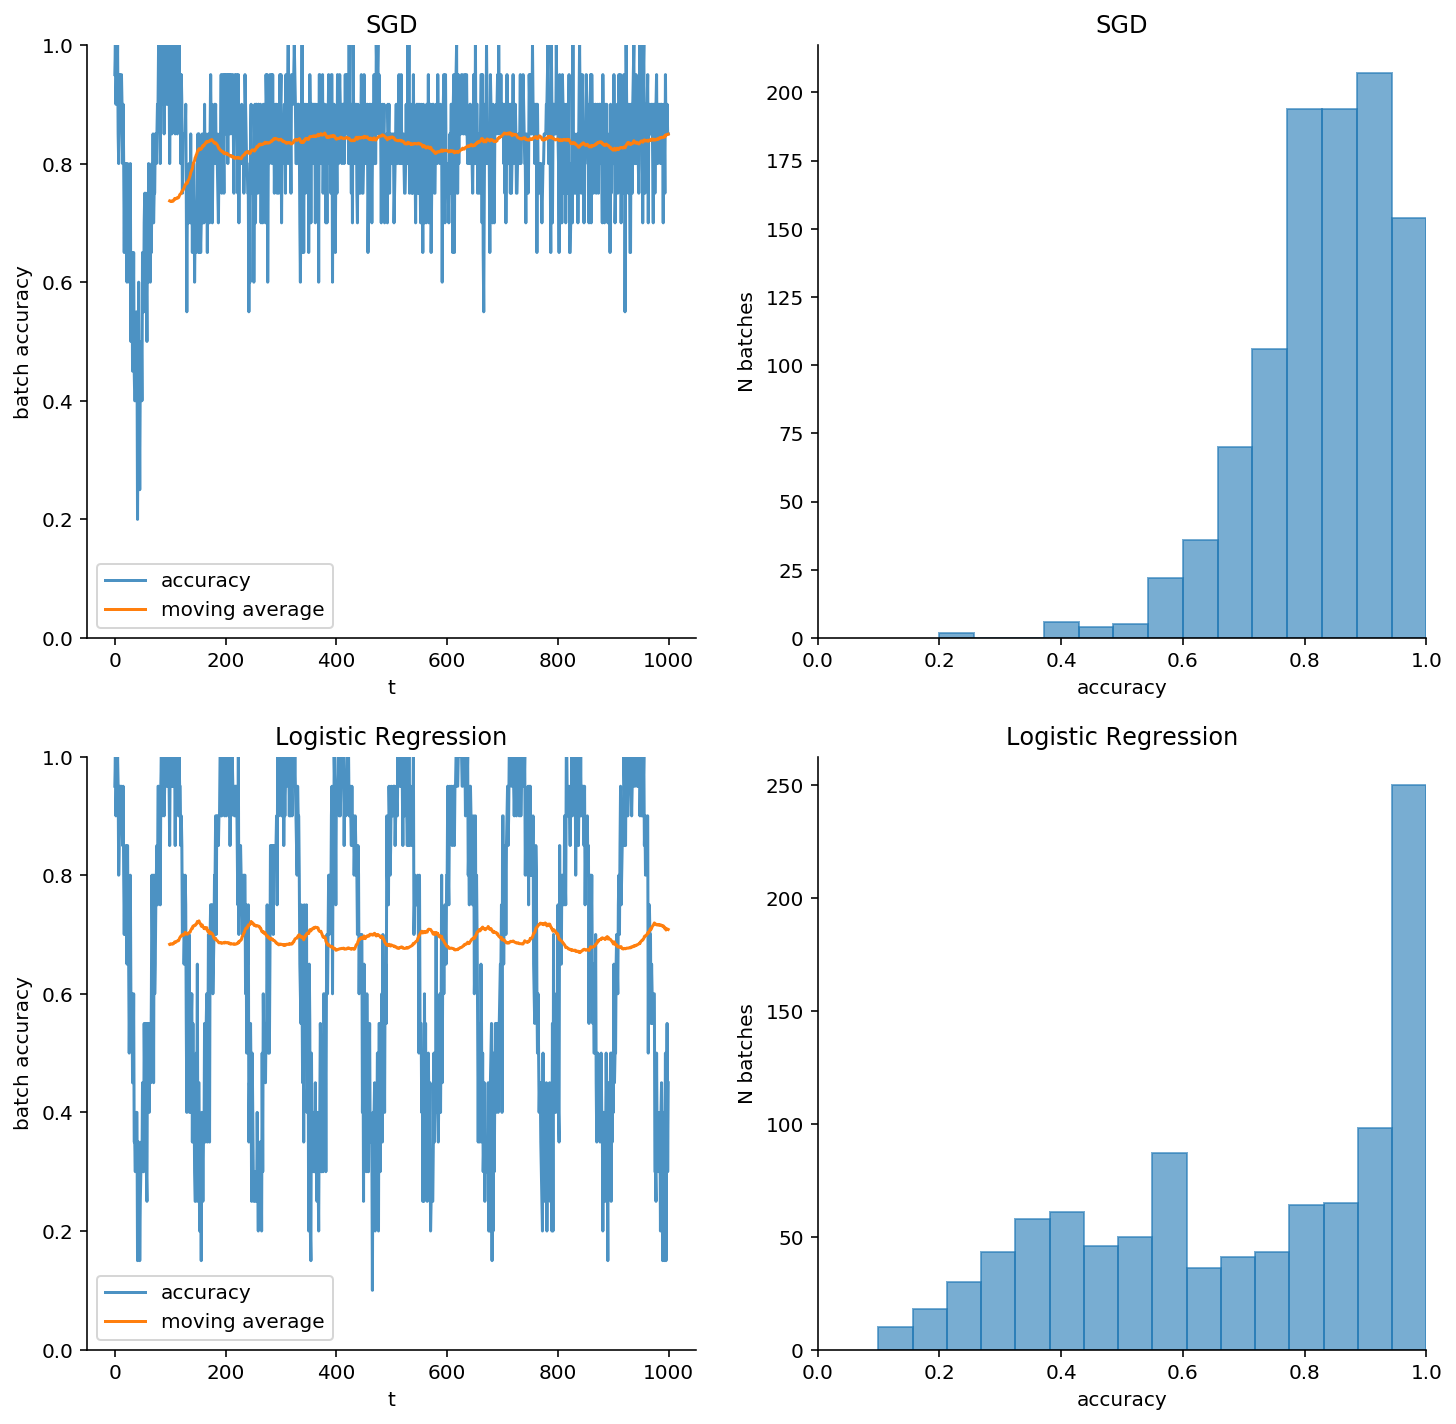

In [13]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N])/ float(N)

f, axarr = plt.subplots(2, 2, figsize = (12,12))

t_int = [(0,99), (700,799), (1400,1499), (1900,1999)]
ax_coord = [[0,0], [0,1], [1,0], [1,1]]

for i in range(2):
    for j in range(2):
        axarr[i,j].spines['top'].set_visible(False)
        axarr[i,j].spines['right'].set_visible(False)
        axarr[i,j].set_xlabel('x1')
        axarr[i,j].set_ylabel('x2')
        
x = update_result[:, 0]
sgd_acc = update_result[:, 1]
lr_acc = update_result[:, 2]

axarr[0,0].plot(x, sgd_acc, label = 'accuracy', alpha = 0.8)
axarr[0,0].plot(x[99:], running_mean(sgd_acc, 100), label = 'moving average')
axarr[0,0].set_ylim(0,1)
axarr[0,0].set_xlabel('t')
axarr[0,0].set_ylabel('batch accuracy')
axarr[0,0].set_title('SGD')
axarr[0,0].legend()


axarr[0,1].hist(sgd_acc, bins = 14, alpha = 0.6, edgecolor='C0')
axarr[0,1].set_xlim(0,1)
axarr[0,1].set_xlabel('accuracy')
axarr[0,1].set_ylabel('N batches')
axarr[0,1].set_title('SGD');

axarr[1,0].plot(x, lr_acc, label = 'accuracy', alpha = 0.8)
axarr[1,0].plot(x[99:], running_mean(lr_acc, 100), label = 'moving average')
axarr[1,0].set_ylim(0,1)
axarr[1,0].set_xlabel('t')
axarr[1,0].set_ylabel('batch accuracy')
axarr[1,0].set_title('Logistic Regression')
axarr[1,0].legend()

axarr[1,1].hist(lr_acc, bins = 16, alpha = 0.6, edgecolor='C0')
axarr[1,1].set_xlim(0,1)
axarr[1,1].set_xlabel('accuracy')
axarr[1,1].set_ylabel('N batches')
axarr[1,1].set_title('Logistic Regression');

# Summary

Online learning looks promising for this scenario. Its called something. Warning- this toy example clean and simple, real world examples may not be so easy- could be a lot to tune, and this tuning may change over time. 

A real world scenario could use a hybrid of batch + online with a bandit algorithm to mediate which algortithm is served. The batch model should retrain every time performance slips (test for if data points are part of distribution or not, trigger a retrain if criteria met)